# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [10]:
results = pd.read_csv("./archive/results.csv", parse_dates=["date"])
#results["date"] = pd.to_datetime(results["date"], dayfirst=True, errors="coerce")
results["date"] = pd.to_datetime(results["date"], format="mixed", dayfirst=True, errors="coerce")

In [11]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [14]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


In [15]:
# OM: revisar estructura del dataset
results.info()
[results.head(5), results.tail(5)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        48532 non-null  datetime64[ns]
 1   home_team   48532 non-null  object        
 2   away_team   48532 non-null  object        
 3   home_score  48532 non-null  int64         
 4   away_score  48532 non-null  int64         
 5   tournament  48532 non-null  object        
 6   city        48532 non-null  object        
 7   country     48532 non-null  object        
 8   neutral     48532 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 3.0+ MB


[        date home_team away_team  home_score  away_score tournament     city  \
 0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
 1 1873-03-08   England  Scotland           4           2   Friendly   London   
 2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
 3 1875-03-06   England  Scotland           2           2   Friendly   London   
 4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   
 
     country  neutral  
 0  Scotland    False  
 1   England    False  
 2  Scotland    False  
 3   England    False  
 4  Scotland    False  ,
             date               home_team away_team  home_score  away_score  \
 48527 2025-09-09  Bosnia and Herzegovina   Austria           1           2   
 48528 2025-09-09                  Cyprus   Romania           2           2   
 48529 2025-09-09                  Norway   Moldova          11           1   
 48530 2025-09-09                 Albania    Latvia

In [ ]:
# OM Cuántos torneos únicos hay en el dataset?
results["tournament"].nunique()

188

In [16]:
# OM ¿Cuál es la fecha del primer partido de copas del mundo  de la FIFA (1930 no tuvo clasificación para la Copa Mundial)?
results.loc[results["tournament"] == "FIFA World Cup", "date"].min()

Timestamp('1930-07-13 00:00:00')

In [17]:
# OM Filtrar el dataset para quedarnos solo con los partidos jugados desde la fecha del primer partido de copa del mundo de la FIFA en adelante. ¿Cuántos partidos hay en este subconjunto? 
results_filtrado = results[results["date"].dt.date >= pd.to_datetime(results.loc[results["tournament"] == "FIFA World Cup", "date"].min()).date()]
results_filtrado["tournament"].value_counts()

tournament
Friendly                                17276
FIFA World Cup qualification             8529
UEFA Euro qualification                  2824
African Cup of Nations qualification     2278
FIFA World Cup                            964
                                        ...  
TIFOCO Tournament                           1
Copa Confraternidad                         1
ConIFA Challenger Cup                       1
Benedikt Fontana Cup                        1
South Asian Super Cup                       1
Name: count, Length: 181, dtype: int64

In [ ]:
# OM Cuántos torneos únicos hay en este subconjunto?
results_filtrado["tournament"].nunique()

181

In [28]:
# OM: A partir de aquí desarrollo el modelo predictivo

# Crear la columna target win/draw/loss basada en el resultado del partido
results_filtrado["goal_diff"] = results_filtrado["home_score"] - results_filtrado["away_score"]

# np.select por defecto usa 0 como default (entero), lo que genera conflicto de dtype con strings.
# Se especifica un default de tipo string para evitar el TypeError.
#results_filtrado["target"] = np.select(
#    [results_filtrado["goal_diff"] > 0, results_filtrado["goal_diff"] == 0, results_filtrado["goal_diff"] < 0],
#    ["win", "draw", "loss"],
#    default="unknown"
#)

results_filtrado = results_filtrado.copy()
sign_map = {1: "win", 0: "draw", -1: "loss"}
results_filtrado["target"] = np.sign(results_filtrado["goal_diff"]).map(sign_map)

# sanity check
assert results_filtrado["target"].isna().sum() == 0

Distribución del target:
target
win     0.489
loss    0.282
draw    0.229
Name: proportion, dtype: float64

Classification report (test):
              precision    recall  f1-score   support

        draw      0.265     0.135     0.179      2156
        loss      0.490     0.447     0.468      2651
         win      0.596     0.763     0.669      4603

    accuracy                          0.530      9410
   macro avg      0.450     0.448     0.438      9410
weighted avg      0.490     0.530     0.500      9410



<Figure size 450x400 with 0 Axes>

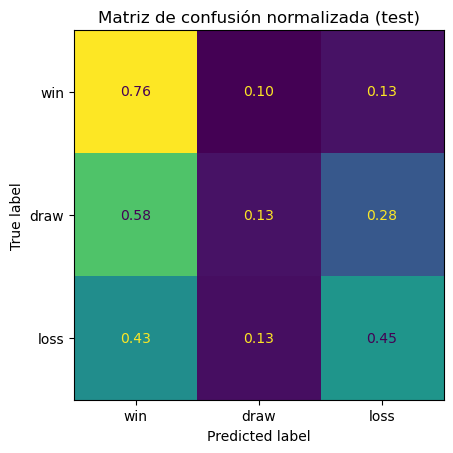


Top 12 importancias:
away_team     0.244065
home_team     0.229111
year          0.214052
month         0.116836
dayofweek     0.099395
tournament    0.085647
neutral       0.010894
dtype: float64


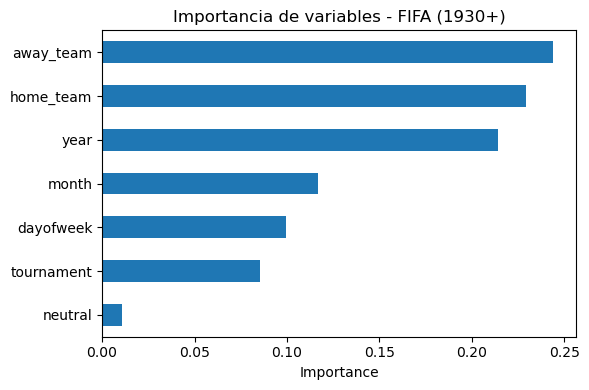

In [29]:
# Distribución (opcional)
print("Distribución del target:")
print(results_filtrado["target"].value_counts(normalize=True).round(3))

# =========================================
# 4) FEATURES base (roles explícitos + numéricas)
# =========================================
results_filtrado["year"] = results_filtrado["date"].dt.year
results_filtrado["month"] = results_filtrado["date"].dt.month
results_filtrado["dayofweek"] = results_filtrado["date"].dt.dayofweek
results_filtrado["neutral"] = results_filtrado["neutral"].astype(int)

feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek"]

X = results_filtrado[feat_cat + feat_num]
y = results_filtrado["target"]

# =========================================
# 5) SPLIT antes de cualquier fit (evita leakage)
# =========================================
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# =========================================
# 6) PREPROCESAMIENTO con ColumnTransformer
#    - TargetEncoder separado por columna (roles explícitos)
#    - Numéricas pasan "as is"
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

pre = ColumnTransformer(
    transformers=[
        # Cada TargetEncoder aprende su mapping usando SOLO el fold de train dentro del Pipeline
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    remainder="drop",
    verbose_feature_names_out=False  # nombres de salida más limpios
)

# =========================================
# 7) MODELO (baseline robusto)
# =========================================
clf = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # para que 'draw' no quede sub-representado
    ))
])

clf.fit(X_tr, y_tr)

# =========================================
# 8) EVALUACIÓN
# =========================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_te)

print("\nClassification report (test):")
print(classification_report(y_te, y_pred, digits=3))

cm = confusion_matrix(y_te, y_pred, labels=["win","draw","loss"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", cmap=None, colorbar=False)
plt.title("Matriz de confusión normalizada (test)")
plt.show()

# =========================================
# 9) IMPORTANCIA DE VARIABLES
#    Nota: tras el preprocesamiento, obtenemos los nombres de features
# =========================================
try:
    # Nombres de salida del ColumnTransformer
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    # Fallback si la versión no soporta get_feature_names_out()
    feature_names = np.array(
        ["home_team_TE", "away_team_TE", "tournament_TE"] + feat_num
    )

# Importancias desde el RandomForest dentro del Pipeline
rf = clf.named_steps["rf"]
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTop 12 importancias:")
print(importances.head(12))

plt.figure(figsize=(6,4))
importances.head(12).sort_values().plot(kind="barh")
plt.title("Importancia de variables - FIFA (1930+)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [22]:
# OM Feature engineering
results_filtrado["year"] = results_filtrado["date"].dt.year
results_filtrado["month"] = results_filtrado["date"].dt.month
results_filtrado["dayofweek"] = results_filtrado["date"].dt.dayofweek
results_filtrado["neutral"] = results_filtrado["neutral"].astype(int)

In [23]:
# OM Creamos los datasets de features y target (entrada y salida)
X = results_filtrado[["tournament", "home_team", "away_team", "neutral", "year", "month", "dayofweek"]]
y = results_filtrado["target"]

In [24]:
# OM Codificación de variables categóricas con Target Encoding

encoder = TargetEncoder()
X_encoded = encoder.fit_transform(X, y)

#Fin modelo propuesto por OM

Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables utiles para visualizaciones

In [ ]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

In [ ]:
results.info()

In [ ]:
results.describe()

#### Visualizaciones de variables numéricas

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

📝 Si bien existen outliers, estos no pueden tratarse como errores ya que son resultados reales de partidos de fútbol.

In [ ]:
sns.lineplot(data=results, x="year", y="total_score")
plt.title("Diferencia de goles en el tiempo")
plt.show()

📝 Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

In [ ]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

In [ ]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#### Visualización de variables categoricas

In [ ]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')


In [ ]:
results.describe(include='category')

Veamos la distribución del target

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

In [ ]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

In [ ]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

📝 De los torneos, se destaca el tipo "amistoso" pero también aparecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial. La cardinalidad de los torneos puede influir al momento de evaluar los modelos.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

In [ ]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 En base al analisis previo, se decide filtrar los datos a partir de 1920. Antes de esa fecha, había más diferencia entre los equipos (mayor diferencia de goles).

Otros filtros a considerar que pueden introducir ruido en el modelo:
* Cardinalidad de los torneos: existen demasiados torneos por lo cual podría ser conveniente centrarse en los mas conocidos.

In [ ]:
results_filtered = results[results["year"] >= 1920].reset_index(drop=True)

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

📝 Como el objetivo es predecir el resultado del partido, no podemos usar los registros como tal ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [ ]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local
results_filtered["home_n_winrate"] = (
    results_filtered.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante
results_filtered['away_n_winrate'] = (
    results_filtered.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)


# Promedio de goles a favor
results_filtered['home_n_avg_gf'] = (
    results_filtered.groupby('home_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_gf'] = (
    results_filtered.groupby('away_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Promedio de goles en contra
results_filtered['home_n_avg_ga'] = (
    results_filtered.groupby('home_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_ga'] = (
    results_filtered.groupby('away_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

In [ ]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Como aparecen valores nulos, se decide imputar estos valores con 1.

In [ ]:
features_nulls = [
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)

Codificamos las variables categoricas:
- result se codifica con LabelEncoder por ser la variable a predecir
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta

In [ ]:
result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])
print("Clases del resultado: ", result_encoder.classes_)

tournament_encoder = TargetEncoder()
results_filtered["tournament_enc"] = tournament_encoder.fit_transform(results_filtered["tournament"], results_filtered["result_enc"])

home_team_encoder = TargetEncoder()
results_filtered["home_team_enc"] = home_team_encoder.fit_transform(results_filtered["home_team"], results_filtered["result_enc"])

away_team_encoder = TargetEncoder()
results_filtered["away_team_enc"] = away_team_encoder.fit_transform(results_filtered["away_team"], results_filtered["result_enc"])

results_filtered["neutral"] = results_filtered["neutral"].astype(int)

📝 Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una **serie temporal**. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada.

In [ ]:
train = results_filtered[results_filtered["date"] < "2015-01-01"]
test = results_filtered[results_filtered["date"] >= "2015-01-01"]
print(f"Train size: {(len(train)/len(results_filtered))*100:.2f} %")
print(f"Test size: {(len(test)/len(results_filtered))*100:.2f} %")

In [ ]:
# Definimos las features que usaremos para el modelo:
features = [
    'home_n_winrate', 'away_n_winrate',
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
    'neutral', 'tournament_enc',
    'home_team_enc', 'away_team_enc',
    'month', 'is_weekend'
]

target = "result_enc"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

Finalmente, se estandarizan las variables para que todas tengan la misma escala.

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.

In [ ]:
# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

#print_classification_results(y_test, y_pred, "Regresión Logística")

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

#print_classification_results(y_test, y_pred, "KNN")

In [ ]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovr', probability=True)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

#print_classification_results(y_test, y_pred, "SVC")

In [ ]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

#print_classification_results(y_test, y_pred, "Árbol de Decisión")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

#print_classification_results(y_test, y_pred, "Random Forest")

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

📝 En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar en la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global y log loss.

In [ ]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    target_names = result_encoder.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

In [ ]:
print_classification_results(y_test, y_pred_logreg, "Regresión Logística")

print_classification_results(y_test, y_pred_knn, "KNN")

print_classification_results(y_test, y_pred_svc, "SVC")

print_classification_results(y_test, y_pred_dtc, "Árbol de Decisión")

print_classification_results(y_test, y_pred_rfc, "Random Forest")

---

📝 No se obtuvieron resultados muy favorables. Algunas cosas a analizar:
- La cantidad de observaciones puede ser insuficiente para entrenar los modelos.
- Alta cardinalidad de los tipos de torneos. Utilizar los mas conocidos o agrupar los menos conocidos en una sola categoria.
- Target con desbalance de clases. Podria ser mas conveniente utilizar un objetivo binario (win/lose).